## Proof of Concept
- convert text to frequency that represents changes in format
- split text based on "major" changes in frequency

In [1]:
%config IPCompleter.greedy=True

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
import re
import numpy as np

from faker import Faker

In [4]:
%%html

<h5>1. setup</h5>

In [5]:
fake = Faker()

In [6]:
document = '\n'

for _ in range(10):
    l = np.random.randint(5, 15)
    document += '  ' + fake.word() + ':  ' + fake.sentence(l) + '\n'

document += '\n' \
     + '     abc: 10     abc: 10     abc: 10    ' + '\n' \
     + '     abc: 10     abc: 10     abc: 10    ' + '\n' \
     + '     abc: 10     abc: 10     abc: 10    ' + '\n' \
     + '     abc: 10     abc: 10     abc: 10    ' + '\n' \
     + '\n' \
     + '     abc: 10     abc: 10     abc: 10    ' + '\n' \
     + '     abc: 10     abc: 10     abc: 10    ' + '\n' \
     + '     abc: 10     abc: 10     abc: 10    ' + '\n' \
     + '     abc: 10     abc: 10     abc: 10    ' + '\n' \

print('example document:')
print('-----------------------------------------')
print(document)
print('-----------------------------------------')

example document:
-----------------------------------------

  Mrs:  Move receive nothing this.
  body:  Decide authority own necessary large admit sing business road short sometimes financial.
  defense:  Often growth challenge condition carry thank much tonight.
  budget:  Direction three factor two life couple plant even face by offer stop hour.
  quite:  Factor work first thing energy give away wonder open wrong if sister age pass school.
  explain:  Sort political article offer before group peace south significant near exactly.
  prevent:  Arm statement her this study exist everybody food.
  conference:  Check let read for section chair bar garden.
  like:  Among country black during imagine democratic finish seat simple difference ago.
  card:  Well good your nature what allow.

     abc: 10     abc: 10     abc: 10    
     abc: 10     abc: 10     abc: 10    
     abc: 10     abc: 10     abc: 10    
     abc: 10     abc: 10     abc: 10    

     abc: 10     abc: 10     abc: 10   

In [7]:
%%html

<h5>2. convert document to matrix</h5>

In [8]:
import sys

sys.path.append('..')

from package.transformers import DocumentToMatrix

In [9]:
##
document_transformer = DocumentToMatrix.BasicDocumentToMatrix(document)
document_as_matrix = document_transformer.transform()

In [10]:
document_as_matrix

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
%%html

<h5>3. image / document</h5>

In [12]:
import matplotlib.pyplot as plt

In [13]:
%%html

<h5>view as image</h5>

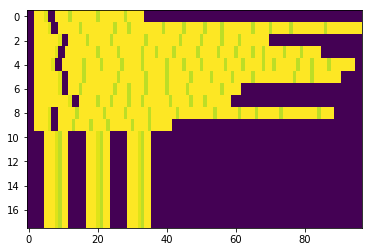

In [14]:
plt.imshow(document_as_matrix, aspect='auto')

In [15]:
%%html

<h5>view as time series</h5>

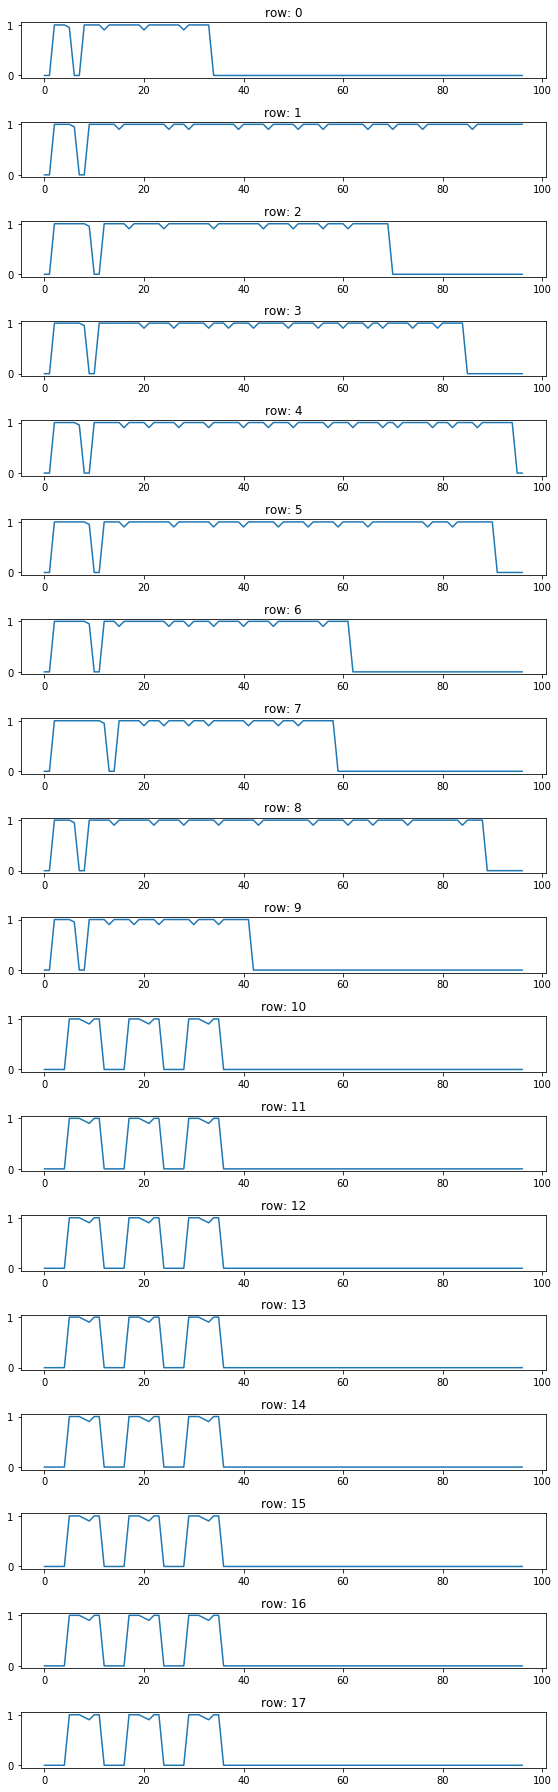

In [16]:
length, _ = document_as_matrix.shape
fig, axs = plt.subplots(length, 1, figsize=(8, 25))

for row in range(length):
    axs[row].plot(document_as_matrix[row, :])
    axs[row].set_title('row: ' + str(row))
    
fig.tight_layout()
fig.show()

In [17]:
%%html

<h5>split document</h5>

In [18]:
import math

def strip_array(array):
    for col in np.flip(range(len(array))):
        if array[col] != 0.0:
            break
    
    return array[:col]

In [19]:
y = []
for row in range(1, length):
    a_orig = document_as_matrix[row-1, :]
    b_orig = document_as_matrix[row, :]
    
    a = strip_array(a_orig)
    b = strip_array(b_orig)

    a_len = len(a)
    b_len = len(b)
    
    value = 0
    if a_len != 0 and b_len != 0:
        if a_len > b_len:
            a = a[:b_len]
        if b_len > a_len:
            b = b[:a_len]

        m = np.array([a, b])
        value = np.corrcoef(m)[0, 1]
        if math.isnan(value):
            value = 0

    y.append(abs(value))

In [20]:
threshold = .35
split_points = [ 
    index + 1
    for index, value
    in enumerate(y)
    if value < threshold 
]

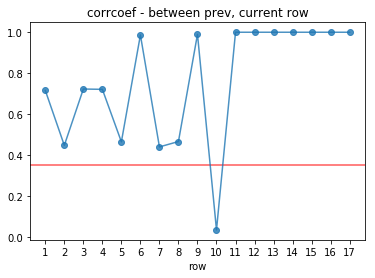

In [21]:
x_ticks = range(length)
plt.xticks(x_ticks)

plt.axhline(.35, c = 'red', alpha = .65)

x = range(1, length)

plt.title('corrcoef - between prev, current row')
plt.xlabel('row')

plt.plot(x, y, '-o', alpha = .8)
plt.show()

In [22]:
sections = []

prev_split_point = 0
for current_split_point in split_points:
    section = document_transformer.lines_in_document[prev_split_point:current_split_point]
    sections.append('\n'.join(section))
        
    prev_split_point = current_split_point
    
section = document_transformer.lines_in_document[prev_split_point:]
sections.append('\n'.join(section))

In [23]:
for index, section in enumerate(sections):
    print('section:', index+1)
    print('-->')
    print(section)
    print('<--')
    print()

section: 1
-->
  Mrs:  Move receive nothing this.
  body:  Decide authority own necessary large admit sing business road short sometimes financial.
  defense:  Often growth challenge condition carry thank much tonight.
  budget:  Direction three factor two life couple plant even face by offer stop hour.
  quite:  Factor work first thing energy give away wonder open wrong if sister age pass school.
  explain:  Sort political article offer before group peace south significant near exactly.
  prevent:  Arm statement her this study exist everybody food.
  conference:  Check let read for section chair bar garden.
  like:  Among country black during imagine democratic finish seat simple difference ago.
  card:  Well good your nature what allow.
<--

section: 2
-->
     abc: 10     abc: 10     abc: 10    
     abc: 10     abc: 10     abc: 10    
     abc: 10     abc: 10     abc: 10    
     abc: 10     abc: 10     abc: 10    
     abc: 10     abc: 10     abc: 10    
     abc: 10     abc: 10  